## Nhập thư viện

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris

## Dữ liệu Iris

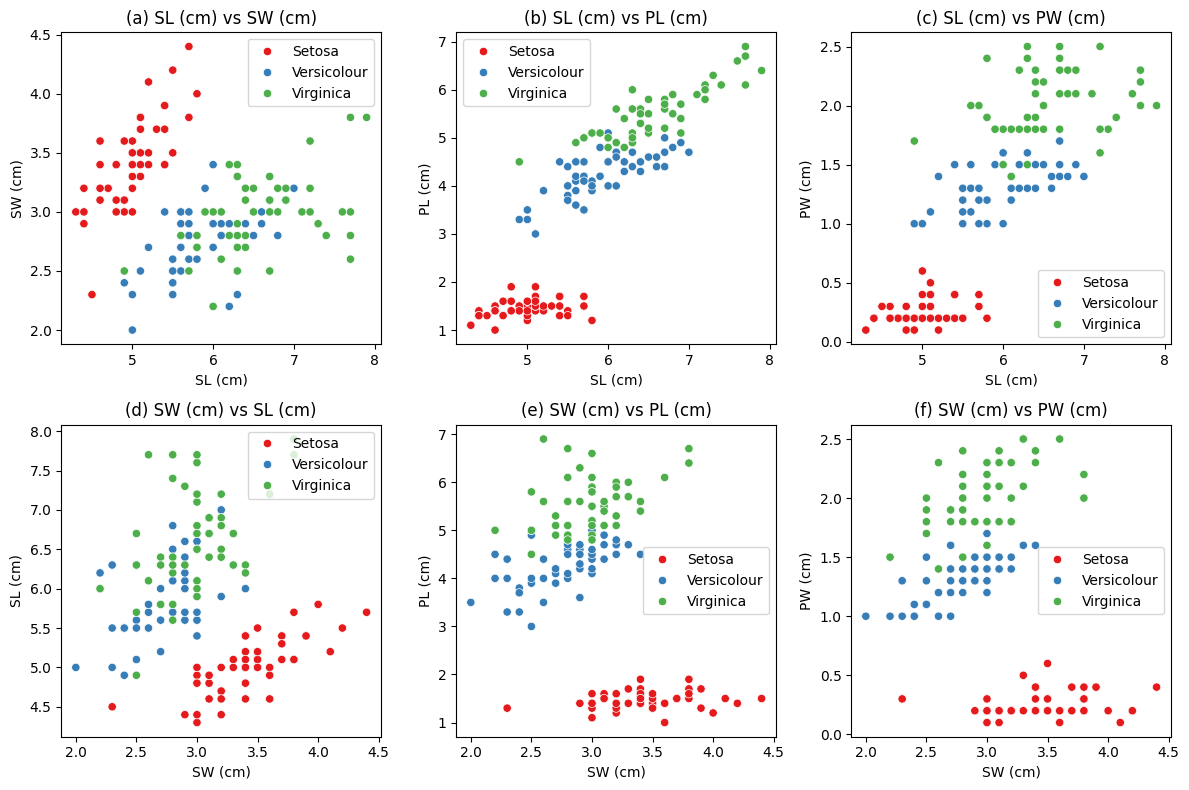

In [52]:
from sklearn import datasets

# Tải dữ liệu Iris từ sklearn
data = datasets.load_iris()

# Chuyển đổi dữ liệu thành DataFrame
iris_df = pd.DataFrame(
    data=data.data, 
    columns=data.feature_names
)
iris_df['species'] = data.target
species_mapping = {0: 'Setosa', 1: 'Versicolour', 2: 'Virginica'}
iris_df['species'] = iris_df['species'].map(species_mapping)

# Đổi tên cột cho dễ đọc
iris_df.columns = ['SL (cm)', 'SW (cm)', 'PL (cm)', 'PW (cm)', 'species']

# Tạo danh sách cặp thuộc tính
attributes = ['SL (cm)', 'SW (cm)', 'PL (cm)', 'PW (cm)']
pair_plots = [(i, j) for i in attributes for j in attributes if i != j]

# Vẽ biểu đồ phân phối từng cặp thuộc tính
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for idx, (x_attr, y_attr) in enumerate(pair_plots[:6]):
    sns.scatterplot(
        data=iris_df, 
        x=x_attr, 
        y=y_attr, 
        hue='species', 
        palette='Set1', 
        ax=axes[idx]
    )
    axes[idx].set_title(f'({chr(97 + idx)}) {x_attr} vs {y_attr}', fontsize=12)
    axes[idx].legend(loc='best')

# Điều chỉnh khoảng cách giữa các biểu đồ
plt.tight_layout()
plt.show()

## Algorithm	1. The process of generating strong classi iers based on Adaboost

#### Cây quyết định đơn (decision stump) 

In [97]:

def decision_stump(X, y, weights):
    """
    Huấn luyện cây quyết định đơn (decision stump) với trọng số.
    
    Parameters:
    - X: Dữ liệu đầu vào (mẫu, thuộc tính)
    - y: Nhãn (-1 hoặc 1)
    - weights: Trọng số của các mẫu
    
    Returns:
    - feature: Thuộc tính được chọn
    - threshold: Ngưỡng tối ưu
    - polarity: Hướng (β = 1 hoặc β = -1)
    - error: Lỗi phân loại tối thiểu
    """
    m, n = X.shape
    best_feature = None
    best_threshold = None
    best_polarity = None
    min_error = float('inf')

    # Duyệt qua tất cả các thuộc tính
    for feature in range(n):
        # Lấy giá trị duy nhất của thuộc tính (để thử làm ngưỡng)
        thresholds = np.unique(X[:, feature])
        
        # Duyệt qua tất cả các ngưỡng
        for threshold in thresholds:
            for polarity in [1, -1]:  # Thử cả hai hướng (β = 1 và β = -1)
                # Dự đoán dựa trên ngưỡng và hướng
                predictions = np.ones(m)
                if polarity == 1:
                    predictions[X[:, feature] <= threshold] = -1
                else:
                    predictions[X[:, feature] > threshold] = -1
                
                # Tính lỗi phân loại
                error = np.sum(weights[predictions != y])
                
                # Lưu lại ngưỡng, hướng, và lỗi nhỏ nhất
                if error < min_error:
                    min_error = error
                    best_feature = feature
                    best_threshold = threshold
                    best_polarity = polarity

    return best_feature, best_threshold, best_polarity, min_error


#### Thuật toán 1

In [54]:
def train_weak_classifiers(X_binary, y_binary, T):
    """
    Train weak classifiers using AdaBoost for binary classification.

    Parameters:
    - X_binary: Features, shape (m, n)
    - y_binary: Labels, shape (m,), values are 1 or -1
    - T: Number of iterations (number of weak classifiers)

    Returns:
    - weak_classifiers: List of weak classifiers (feature, threshold, polarity)
    - alphas: List of alpha values for each weak classifier
    """
    N = len(y_binary)
    weights = np.ones(N) / N
    weak_classifiers = []
    alphas = []

    for t in range(T):
        # Train weak classifier using current weights
        feature, threshold, polarity, error = decision_stump(X_binary, y_binary, weights)

        # Calculate predictions of the weak classifier
        predictions = np.ones(N)
        predictions[X_binary[:, feature] * polarity < threshold * polarity] = -1

        # Calculate weighted error and clip for numerical stability
        error = np.sum(weights * (predictions != y_binary))
        error = max(min(error, 1 - 1e-10), 1e-10)

        # Calculate alpha (classifier weight)
        alpha = 0.5 * np.log((1 - error) / error)

        # Update weights
        weights *= np.exp(-alpha * y_binary * predictions)
        weights /= np.sum(weights)  # Normalize weights

        # Store weak classifier and alpha
        weak_classifiers.append((feature, threshold, polarity))
        alphas.append(alpha)

    return weak_classifiers, alphas


In [55]:
def adaboost_train_strong_classifiers(D_X, D_y, Nc, T):
    """
    Train strong classifiers for all pairs of classes using AdaBoost.

    Parameters:
    - D_X: Features, shape (m, n)
    - D_y: Labels, shape (m,), with class indices from 0 to Nc - 1
    - Nc: Number of classes
    - T: Number of iterations (number of weak classifiers)

    Returns:
    - strong_classifiers: List of strong classifiers for each pair of classes (i, j).
        Each element is a tuple (i, j, strong_classifier_function, alphas).
    """
    X_train, y_train = D_X, D_y
    strong_classifiers = []

    for i in range(Nc - 1):
        for j in range(i + 1, Nc):
            # Create binary dataset for classes i and j
            binary_mask = (y_train == i) | (y_train == j)
            X_binary, y_binary = X_train[binary_mask], y_train[binary_mask]
            y_binary = np.where(y_binary == i, 1, -1)

            # Train weak classifiers for the binary dataset
            weak_classifiers, alphas = train_weak_classifiers(X_binary, y_binary, T)

            # Create strong classifier function
            def strong_classifier(X, weak_classifiers=weak_classifiers, alphas=alphas):
                final_prediction = np.zeros(X.shape[0])
                for alpha, (feature, threshold, polarity) in zip(alphas, weak_classifiers):
                    prediction = np.ones(X.shape[0])
                    prediction[X[:, feature] * polarity < threshold * polarity] = -1
                    final_prediction += alpha * prediction
                return np.sign(final_prediction)

            # Add strong classifier for class pair (i, j)
            strong_classifiers.append((i, j, strong_classifier, alphas))

    return strong_classifiers


In [56]:
# Load Iris dataset
iris = load_iris()
X = iris.data  # Features
y = iris.target  # Labels

# Select 40 samples from each class for training, remaining for testing
np.random.seed(42)
train_indices = []
test_indices = []
for class_label in np.unique(y):
    class_indices = np.where(y == class_label)[0]
    np.random.shuffle(class_indices)
    train_indices.extend(class_indices[:40])
    test_indices.extend(class_indices[40:])

# Split into training and testing sets
train_indices = np.array(train_indices)
test_indices = np.array(test_indices)
X_train, y_train = X[train_indices], y[train_indices]
X_test, y_test = X[test_indices], y[test_indices]

# Train strong classifiers using Adaboost
Nc = len(np.unique(y_train))  # Number of classes
T = 50  # Number of weak classifiers
strong_classifiers = adaboost_train_strong_classifiers(X_train, y_train, Nc, T)

# Test the classifiers
for i, j, strong_classifier, _ in strong_classifiers:
    predictions = strong_classifier(X_test)
    print(f"Strong classifier for classes {i} and {j}:")
    print(predictions)

Strong classifier for classes 0 and 1:
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
Strong classifier for classes 0 and 2:
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
Strong classifier for classes 1 and 2:
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.
  1.  1. -1. -1.  1. -1. -1. -1. -1.  1. -1. -1.]


#### Figure 5

In [57]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load Iris dataset
iris = load_iris()
X = iris.data[:, :2]  # Use the first two features (SL and SW)
y = iris.target

# Encode target labels as -1 and 1 for binary classification
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Select 40 samples per class for training, remaining for testing
train_indices, test_indices = [], []
for label in np.unique(y):
    label_indices = np.where(y == label)[0]
    selected_indices = np.random.choice(label_indices, 40, replace=False)
    train_indices.extend(selected_indices)
    test_indices.extend(np.setdiff1d(label_indices, selected_indices))

X_train, y_train = X[train_indices], y_encoded[train_indices]
X_test, y_test = X[test_indices], y_encoded[test_indices]

# Train AdaBoost strong classifiers for each binary classification process
processes = []
for i, target_class in enumerate(np.unique(y)):
    # Create binary labels for the current classification process
    y_binary = np.where(y_train == target_class, 1, -1)

    # Train weak classifiers for this process
    weak_classifiers, _ = train_weak_classifiers(X_train, y_binary, T=5)  # Limit to 5 weak classifiers
    processes.append((i + 1, weak_classifiers))

# Collect results in a DataFrame
results = []
for i, weak_classifiers in processes:
    for j, (feature, threshold, polarity) in enumerate(weak_classifiers):
        results.append({
            "Feature": "SL" if feature == 0 else "SW",
            "Value": threshold,
            "i": i,
            "j": j + 1
        })

results_df = pd.DataFrame(results)
print(results_df)

   Feature  Value  i  j
0       SL    5.4  1  1
1       SW    3.2  1  2
2       SL    5.7  1  3
3       SL    4.8  1  4
4       SW    2.9  1  5
5       SW    2.9  2  1
6       SW    2.4  2  2
7       SL    5.1  2  3
8       SW    2.0  2  4
9       SL    5.1  2  5
10      SL    6.1  3  1
11      SL    7.0  3  2
12      SW    2.8  3  3
13      SL    5.5  3  4
14      SL    7.0  3  5


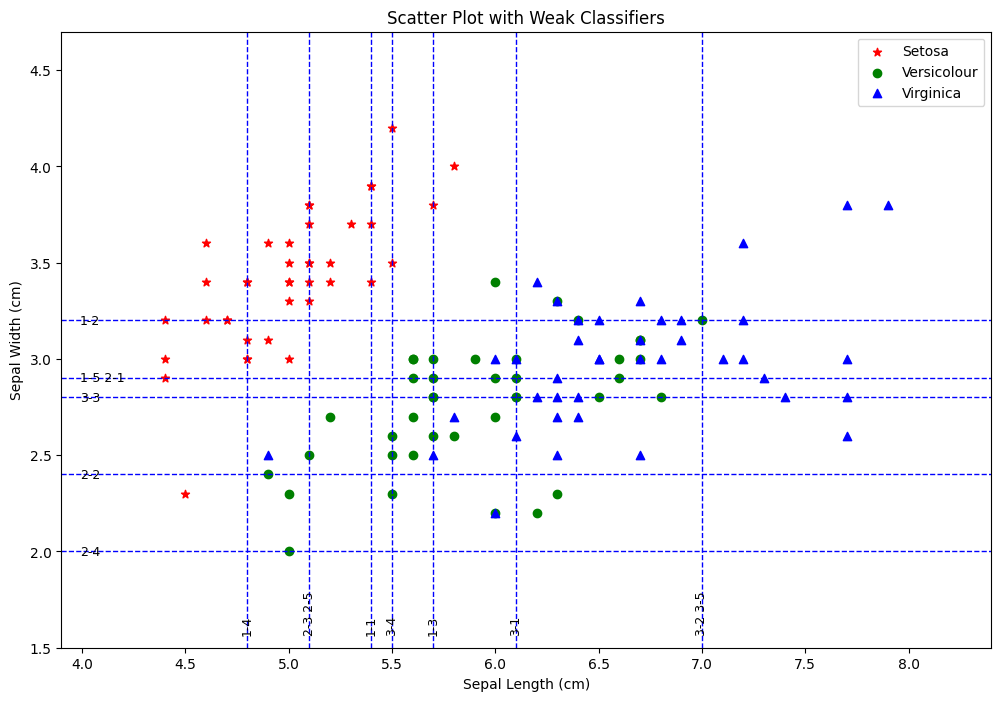

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Load Iris dataset
iris = load_iris()
X = iris.data[:, :2]  # Use the first two features (Sepal Length and Sepal Width)
y = iris.target

# Select 40 samples per class for training, remaining for testing
train_indices, test_indices = [], []
for label in np.unique(y):
    label_indices = np.where(y == label)[0]
    selected_indices = np.random.choice(label_indices, 40, replace=False)
    train_indices.extend(selected_indices)
    test_indices.extend(np.setdiff1d(label_indices, selected_indices))

X_train, y_train = X[train_indices], y[train_indices]
X_test, y_test = X[test_indices], y[test_indices]

# Train AdaBoost with 10 weak classifiers
T = 5
weak_classifiers = train_weak_classifiers(X_train, y_train, T)
import matplotlib.pyplot as plt
import numpy as np

def plot_from_results_fixed(X, y, results_df):
    """
    Vẽ biểu đồ phân tán với các dòng từ bảng kết quả, gom nhóm các cặp i-j trên cùng một đường.
    """
    # Thiết lập không gian biểu đồ
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # Danh sách màu sắc cho các dòng
    colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink']

    # Vẽ biểu đồ phân tán
    plt.figure(figsize=(12, 8))
    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], c='red', label='Setosa', marker='*')
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], c='green', label='Versicolour', marker='o')
    plt.scatter(X[y == 2][:, 0], X[y == 2][:, 1], c='blue', label='Virginica', marker='^')

    # Gom nhóm các cặp i-j trên cùng một đường
    grouped_lines = {}
    for _, row in results_df.iterrows():
        feature = row["Feature"]
        value = row["Value"]
        i = row["i"]
        j = row["j"]

        key = (feature, value)
        if key not in grouped_lines:
            grouped_lines[key] = []
        grouped_lines[key].append(f"{i}-{j}")

    # Vẽ các dòng và hiển thị text
    for idx, ((feature, value), labels) in enumerate(grouped_lines.items()):
        color = colors[idx % len(colors)]  # Chọn màu cho dòng

        # Tạo chuỗi text từ các cặp i-j
        label_text = " ".join(labels)

        if feature == "SL":  # Sepal Length → dòng thẳng đứng
            plt.axvline(x=value, color='blue', linestyle='--', linewidth=1)
            plt.text(value, y_min + (y_max - y_min) * 0.02, label_text, color='black', fontsize=9, 
                     ha='center', va='bottom', rotation=90)  # Xoay dọc text
        elif feature == "SW":  # Sepal Width → dòng ngang
            plt.axhline(y=value, color='blue', linestyle='--', linewidth=1)
            plt.text(x_min + (x_max - x_min) * 0.02, value, label_text, color='black', fontsize=9, 
                     ha='left', va='center')  # Căn trái, bên trong biểu đồ

    # Thiết lập nhãn và tiêu đề
    plt.xlabel('Sepal Length (cm)')
    plt.ylabel('Sepal Width (cm)')
    plt.legend(loc='upper right')
    plt.title('Scatter Plot with Weak Classifiers')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.show()

# Gọi hàm với dữ liệu và bảng kết quả
plot_from_results_fixed(X_train, y_train, results_df)



#### Figure 6

In [60]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load Iris dataset
iris = load_iris()
X = iris.data[:, :2]  # Use the first two features (SL and SW)
y = iris.target

# Encode target labels as -1 and 1 for binary classification
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Select 40 samples per class for training, remaining for testing
train_indices, test_indices = [], []
for label in np.unique(y):
    label_indices = np.where(y == label)[0]
    selected_indices = np.random.choice(label_indices, 40, replace=False)
    train_indices.extend(selected_indices)
    test_indices.extend(np.setdiff1d(label_indices, selected_indices))

X_train, y_train = X[train_indices], y_encoded[train_indices]
X_test, y_test = X[test_indices], y_encoded[test_indices]

# Train AdaBoost strong classifiers for each binary classification process
processes = []
for i, target_class in enumerate(np.unique(y)):
    # Create binary labels for the current classification process
    y_binary = np.where(y_train == target_class, 1, -1)

    # Train weak classifiers for this process
    weak_classifiers, alphas = train_weak_classifiers(X_train, y_binary, T=5)  # Limit to 5 weak classifiers
    processes.append((i + 1, weak_classifiers, alphas))

# Collect results in a DataFrame
results = []
for i, weak_classifiers, alphas in processes:
    for j, ((feature, threshold, polarity), alpha) in enumerate(zip(weak_classifiers, alphas)):
        results.append({
            "Feature": "SL" if feature == 0 else "SW",
            "Value": threshold,
            "Polarity": polarity,
            "i": i,  # Target class
            "j": j + 1,  # Weak classifier index
            "Alpha": alpha,  # Trọng số của bộ phân loại yếu
            "Target": label_encoder.inverse_transform([i - 1])[0]  # Target class label
        })

results_df = pd.DataFrame(results)
print(results_df)

   Feature  Value  Polarity  i  j     Alpha  Target
0       SL    5.4        -1  1  1  1.198948       0
1       SW    3.3         1  1  2  1.073855       0
2       SL    5.8        -1  1  3  0.732128       0
3       SL    4.8        -1  1  4  0.749614       0
4       SW    2.9         1  1  5  0.769592       0
5       SW    2.9        -1  2  1  0.549306       1
6       SW    2.4        -1  2  2  0.321775       1
7       SL    5.3         1  2  3  0.306698       1
8       SW    2.4        -1  2  4  0.222311       1
9       SL    7.0        -1  2  5  0.233435       1
10      SL    6.2         1  3  1  0.746963       2
11      SL    7.0         1  3  2  0.355646       2
12      SW    2.8        -1  3  3  0.305092       2
13      SL    5.5         1  3  4  0.269617       2
14      SL    7.0         1  3  5  0.131491       2


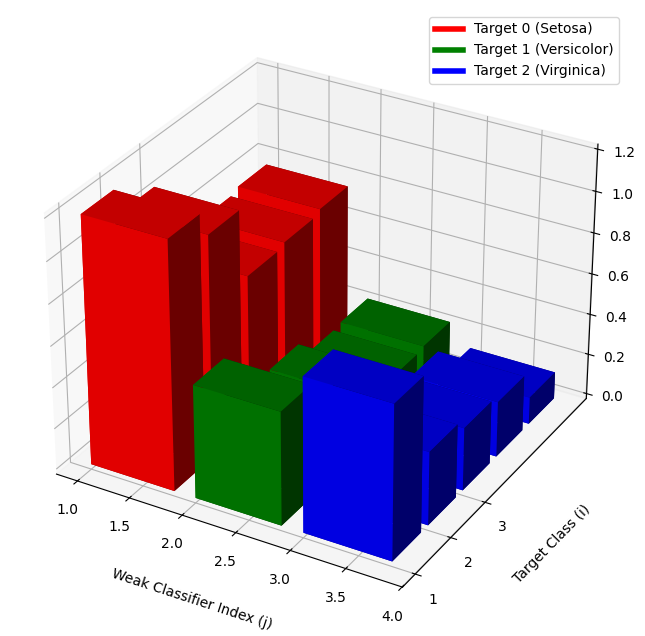

In [96]:
import matplotlib.pyplot as plt
import numpy as np

# Dữ liệu từ results_df
i = results_df['i'].values  # Target class (1, 2, 3)
j = results_df['j'].values  # Weak classifier index
alpha = results_df['Alpha'].values  # Trọng số alpha
targets = results_df['Target'].values  # Target class labels

# Màu sắc dựa trên target
colors = ['red' if target == 0 else 'green' if target == 1 else 'blue' for target in targets]

# Tạo biểu đồ 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Vẽ các cột
dx = dy = 0.8  # Tăng độ rộng của các cột (rộng hơn nữa)
dz = alpha  # Chiều cao của các cột
x = i  # Trục x đại diện cho j (Weak Classifier Index)
y = j  # Trục y đại diện cho i (Target class)
z = np.zeros(len(alpha))  # Đáy của các cột (z=0)

# Vẽ cột 3D
ax.bar3d(x, y, z, dx, dy, dz, color=colors, shade=True)

# # Ghi giá trị alpha trên đỉnh mỗi cột
# offset = 0.25  
# for xi, yi, zi, ai in zip(x, y, dz, alpha):
#     ax.text(
#         xi + dx / 2 ,  # Căn giữa theo trục x
#         yi + dy / 2 + offset,  # Thêm khoảng cách theo trục y
#         zi + 0.05,  # Đặt text ngay trên đỉnh cột
#         f"{ai:.2f}", color='black', ha='center', fontsize=12, weight='bold'
#     )

# Nhãn trục
ax.set_xlabel('Weak Classifier Index (j)', labelpad=15)  # Trục x là j
ax.set_ylabel('Target Class (i)', labelpad=15)  # Trục y là i
ax.set_zlabel('Alpha (Weight)', labelpad=15)

# Cố định các ticks trên trục y (chỉ hiển thị 1, 2, 3)
ax.set_yticks([1, 2, 3])  # Trục y chỉ có các giá trị 1, 2, 3

# Thêm chú thích
custom_lines = [
    plt.Line2D([0], [0], color='red', lw=4, label='Target 0 (Setosa)'),
    plt.Line2D([0], [0], color='green', lw=4, label='Target 1 (Versicolor)'),
    plt.Line2D([0], [0], color='blue', lw=4, label='Target 2 (Virginica)')
]
ax.legend(handles=custom_lines, loc='upper right', fontsize=10)

# Hiển thị biểu đồ
plt.show()


##  Algorithm 2. The method to determine BPA

#### Thuật toán 2

In [98]:
def apply_dempster_rule(m_k, N_C):
    """
    Áp dụng quy tắc kết hợp của Dempster cho một BPA.
    Parameters:
    - m_k: Vector BPA hiện tại, shape (N_C,)
    - N_C: Số lượng lớp

    Returns:
    - combined_m: BPA sau khi kết hợp, shape (N_C,)
    """
    combined_m = np.zeros(N_C)
    denominator = 1 - sum(m_k[i] * m_k[j] for i in range(N_C) for j in range(N_C) if i != j)
    if denominator == 0:
        raise ValueError("Denominator in Dempster's rule is zero. Check input BPA values.")

    for i in range(N_C):
        for j in range(N_C):
            if i != j:
                combined_m[i] += (m_k[i] * m_k[j]) / denominator
    return combined_m / combined_m.sum()  # Normalize


In [101]:
def algorithm_2(D_X, D_y, N_C, n, T, P_X, P_y, T_s):
    """
    Tính BPA cho tất cả các mẫu trong tập kiểm tra P bằng cách áp dụng Dempster's Rule of Combination.

    Parameters:
    - D_X: Tập huấn luyện (features)
    - D_y: Tập huấn luyện (labels)
    - N_C: Số lượng lớp
    - n: Số lượng thuộc tính (features)
    - T: Số lần lặp (bộ phân loại yếu)
    - P_X: Tập kiểm tra (features)
    - P_y: Tập kiểm tra (labels)
    - T_s: Số lượng mẫu kiểm tra

    Returns:
    - BPA: Ma trận BPA cho tất cả các mẫu trong P_X, shape (T_s, N_C)
    """
    BPA = np.zeros((T_s, N_C))  # Ma trận BPA tổng cho tất cả các mẫu kiểm tra

    # Lặp qua tất cả các cặp thuộc tính (i, j)
    for i in range(n - 1):
        for j in range(i + 1, n):
            # Thiết lập tập huấn luyện mới D_(i,j)
            binary_D_X = D_X[:, [i, j]]

            # Huấn luyện các bộ phân loại mạnh bằng Thuật toán 1
            strong_classifiers = adaboost_train_strong_classifiers(binary_D_X, D_y, N_C, T)

            # Thiết lập tập kiểm tra mới P_(i,j)
            binary_P_X = P_X[:, [i, j]]

            # Lặp qua tất cả các mẫu kiểm tra trong P_(i,j)
            for k in range(T_s):
                p_k = binary_P_X[k, :]

                # BPA tạm thời cho mẫu kiểm tra hiện tại p_k
                m_temp = np.zeros(N_C)

                # Lặp qua tất cả các bộ phân loại mạnh H_(i,j)
                for strong_classifier in strong_classifiers:
                    class_i, class_j, strong_func, alpha_values = strong_classifier

                    # Dự đoán với bộ phân loại mạnh
                    h_t = strong_func(p_k.reshape(1, -1))

                    # Tính m_t(i) và m_t(j)
                    total_alpha = sum(alpha_values)

                    m_t_i = np.sum([alpha for alpha, pred in zip(alpha_values, h_t) if pred > 0]) / total_alpha
                    m_t_j = 1 - m_t_i

                    # Phân phối trọng số qua các lớp i và j
                    m_temp[class_i] += m_t_i
                    m_temp[class_j] += m_t_j

                # Chuẩn hóa BPA tạm thời cho mẫu hiện tại
                m_temp /= len(strong_classifiers)
                
                # Áp dụng công thức (17) để phân bổ lại khối lượng nếu p_(i,j)(k) thuộc vùng giao
                if np.any(m_temp > 1):  # Kiểm tra vùng giao
                    for l in range(2, N_C + 1):
                        m_temp = np.array([
                            m_temp[l] * (1 - np.sum(m_temp)) if m_temp[l] <= 1 else m_temp[l]
                            for l in range(N_C)
                        ])
                # Thêm m_temp vào BPA tổng thể cho p_k
                BPA[k, :] += m_temp

    final_BPA = np.zeros((T_s, N_C))
    for k in range(T_s):
        final_BPA[k, :] = apply_dempster_rule(BPA[k, :], N_C)

    return final_BPA

#### Figure 7

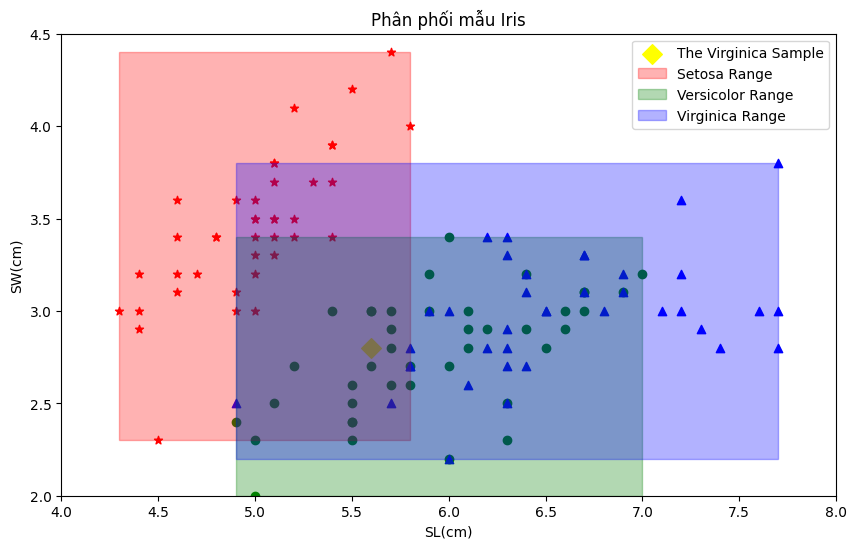

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Tải tập dữ liệu Iris
iris = load_iris()
X = iris.data  # Dữ liệu đặc trưng (SL - Sepal Length, SW - Sepal Width, PL, PW)
y = iris.target  # Nhãn lớp

# Lấy thuộc tính Sepal Length (SL) và Sepal Width (SW) để vẽ
X = X[:, :2]  # Chỉ giữ SL và SW

# Phân chia tập dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Xác định giới hạn của mỗi vùng dựa trên tập huấn luyện
class_ranges = {
    0: {"min": X_train[y_train == 0].min(axis=0), "max": X_train[y_train == 0].max(axis=0)},
    1: {"min": X_train[y_train == 1].min(axis=0), "max": X_train[y_train == 1].max(axis=0)},
    2: {"min": X_train[y_train == 2].min(axis=0), "max": X_train[y_train == 2].max(axis=0)},
}

# Tạo vùng phân phối cho từng lớp
def plot_rectangles(ax):
    colors = ['red', 'green', 'blue']
    labels = ['Setosa Range', 'Versicolor Range', 'Virginica Range']
    for cls, color, label in zip(class_ranges.keys(), colors, labels):
        min_vals = class_ranges[cls]["min"]
        max_vals = class_ranges[cls]["max"]
        ax.add_patch(plt.Rectangle(
            (min_vals[0], min_vals[1]),  # Góc dưới bên trái
            max_vals[0] - min_vals[0],  # Chiều rộng
            max_vals[1] - min_vals[1],  # Chiều cao
            color=color, alpha=0.3, label=label
        ))

# Tạo biểu đồ
fig, ax = plt.subplots(figsize=(10, 6))

# Vẽ điểm dữ liệu từ tập huấn luyện
for cls, color, marker in zip(
    np.unique(y_train), ['red', 'green', 'blue'], ['*', 'o', '^']
):
    idx = y_train == cls
    ax.scatter(
        X_train[idx, 0], X_train[idx, 1], color=color, marker=marker
    )

# Vẽ điểm mẫu kiểm tra (ví dụ một điểm mẫu với SL=5.6 và SW=2.8)
sample = np.array([5.6, 2.8])
ax.scatter(
    sample[0], sample[1], color='yellow', s=100, marker='D', label='The Virginica Sample'
)

# Vẽ vùng hình chữ nhật
plot_rectangles(ax)

# Cài đặt nhãn và chú thích
ax.set_xlabel("SL(cm)")
ax.set_ylabel("SW(cm)")
ax.set_xlim(4, 8)
ax.set_ylim(2, 4.5)

# Đặt thứ tự chú thích
handles, labels = ax.get_legend_handles_labels()
ordered_handles = [handles[0], handles[1], handles[2], handles[3]]
ordered_labels = [labels[0], labels[1], labels[2], labels[3]]
ax.legend(ordered_handles, ordered_labels, loc="upper right")

plt.grid(False)
plt.title("Phân phối mẫu Iris")
plt.show()


#### Figure 8